<a href="https://colab.research.google.com/github/svhenrique/pi-opencv-basic/blob/main/OperacoesMorfologicas_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fontes:

*   https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1
*   https://www.mathworks.com/help/images/morphological-dilation-and-erosion.html
*   https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/
*   https://docs.opencv.org/master/d4/d76/tutorial_js_morphological_ops.html



In [4]:
# detectando drive
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [132]:
# importando bibliotecas 
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
from PIL import Image

## Preparando imagens 

In [9]:
# caminho de pasta imagens
image_path = "/content/drive/My Drive/images/"

In [10]:
os.listdir(image_path)

['coins.jpg', 'lena.jpg', 'prima.jpeg']

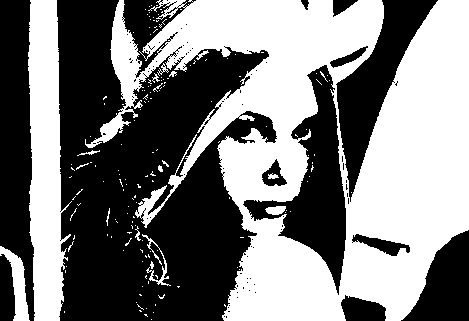

In [11]:
# lendo imagem Lenna e convertendo para preto e branco (binário)
# lembrando que a converção para preto e branco (binário) utiliza pesos com resultados empíricos
lena = cv2.imread(image_path + 'lena.jpg')
lena = cv2.resize(lena, None, fx=.52, fy=.52)
lena = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)
ret,lena = cv2.threshold(lena,100,255,cv2.THRESH_BINARY)
cv2_imshow(lena)

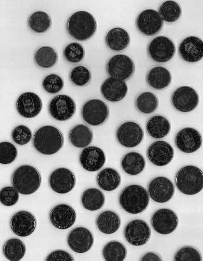

In [136]:
# lendo imagem coins
coins = cv2.imread(image_path + 'coins.jpg')
coins = cv2.resize(coins, None, fx=.52, fy=.52)
cv2_imshow(lena)

## Preparando máscara

In [7]:
class Mask:
  """
    Máscara que sempre terá o pixel alvo no centro
    mask: kernel usado para processamento
    up_down: quantas linhas existem acima e a baixo do alvo 
    left_right: quantas colunas existem aos lados do alvo
  """
  mask = []
  up_down = 0
  left_right = 0

  def __init__(self, mask):
    self.mask = mask
    self.up_down = len(mask)//2
    self.left_right = len(mask)//2

## Erosão

In [134]:
def kernel_erosion_aplication(image, mask, row, pixel):

  """
    Se os 1's da máscara estiverem posicionados igualmente com os 255 da imagem, retornará 255
    se não, retornará 0
  """

  shape = image.shape
  top_area = (row - mask.up_down)
  bottom_area = (row + mask.up_down)
  left_area = (pixel - mask.left_right)
  right_area = (pixel + mask.left_right)

  # se a máscara não couber na área para processar, retorne 0
  if top_area < 0 or left_area < 0 or bottom_area >= shape[0] or right_area >= shape[1]:
    return 0
  
  # area da imagem com máscara
  masked_area = [row[left_area:right_area+1] for row in image[top_area:bottom_area+1]]

  mask = mask.mask
  rows = len(mask)

  for row in range(rows):
    for pixel in range(len(mask[row])):      

      # se a máscara apontar para o elemento 1 mas o pixel apontado for 0, retorne 0
      if mask[row][pixel] == 1 and masked_area[row][pixel] == 0:
        return 0

  # se todas as operações para retorno do 0 não acontecerem, retorne 255
  return 255

def erosion(mask, image):
  shape = image.shape
  image_list = image.tolist()
  result = []

  # percorre os pixels da imagem e processa usando a máscara
  for row in range(shape[0]):
      result_row = []
      for pixel in range(len(image_list[row])):
        masked_area_result = kernel_erosion_aplication(image, mask, row, pixel)
        result_row.append(masked_area_result)
      result.append(result_row)

  # retorna array para formato conhecido pelo opencv
  return np.asarray(result,  dtype=np.uint8)

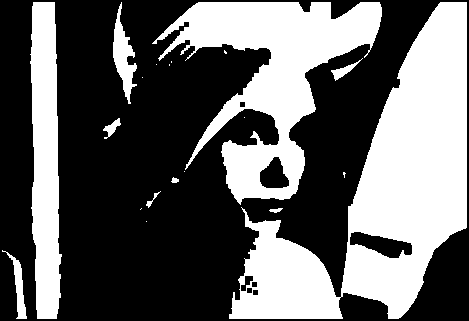

In [135]:
# utilizando máscara 5x5 com matriz em listas no python
mask = [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1], 
        [1, 1, 1, 1, 1], 
        [1, 1, 1, 1, 1]]

# fazendo operação de erosão
mask = Mask(mask)
lena_erosion = erosion(mask, lena)
cv2_imshow(lena_erosion)

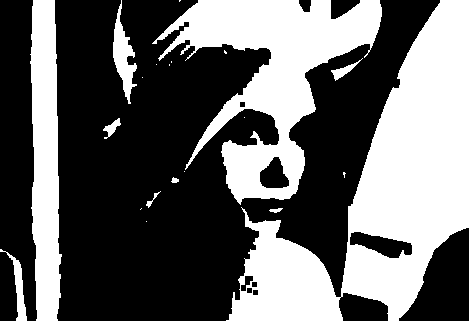

In [ ]:
# utilizando máscara 5x5 do numpy 
# processando erosão da mesma imagem anterior com opencv
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(lena,kernel, iterations=1)
cv2_imshow(erosion)

In [ ]:
# utilizando máscara 3x3 com matriz em listas no python
mask = [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]

# fazendo operação de erosão
mask = Mask(mask)
coins = erosion(mask, lena)
cv2_imshow(lena_erosion)

## Dilatação

In [128]:
def kernel_dilation_aplication(image, mask, row, pixel):

  """
    Se os 1's da máscara estiverem posicionados com ao menos um pixel de 255 da imagem, retornará 255
    se não, retornará 0
  """

  shape = image.shape
  top_area = row - mask.up_down
  bottom_area = row + mask.up_down
  left_area = pixel - mask.left_right
  right_area = pixel + mask.left_right
  mask = [row.copy() for row in mask.mask]

  # caso existam colunas faltantes na parte de cima
  if top_area < 0:
    mask = mask[abs(top_area):]
    top_area += abs(top_area)
    
  # caso existam linhas faltantes no fundo 
  elif bottom_area >= shape[0]:
    mask = mask[:(bottom_area - shape[0] - 1)]
    bottom_area -= bottom_area - shape[0] - 1

  # caso existam colunas faltantes a esquerda
  if left_area < 0:
    for row in range(len(mask)):
      mask[row] = mask[row][abs(left_area):]
    left_area += abs(left_area)

  # caso existam colunas faltantes a direita
  elif right_area >= shape[1]:
    for row in range(len(mask)):
      mask[row] = mask[row][:(right_area - shape[1] - 1)]
    right_area -= right_area - shape[1] - 1

  # area da imagem com máscara
  masked_area = [row[left_area:right_area+1] for row in image[top_area:bottom_area+1]]

  for row in range(len(mask)):
    for pixel in range(len(mask[row])):      
      
      # se a máscara apontar para o elemento 1 mas o pixel apontado for 255, retorne 255
      if mask[row][pixel] == 1 and masked_area[row][pixel] == 255:
        return 255

  # se todas as operações para retorno do 255 não acontecerem, retorne 0
  return 0

def dilation(mask, image):
  shape = image.shape
  image_list = image.tolist()
  result = []
  for row in range(shape[0]):
      result_row = []
      for pixel in range(len(image_list[row])):
        masked_area_result = kernel_dilation_aplication(image, mask, row, pixel)
        result_row.append(masked_area_result)
      result.append(result_row)
  return result

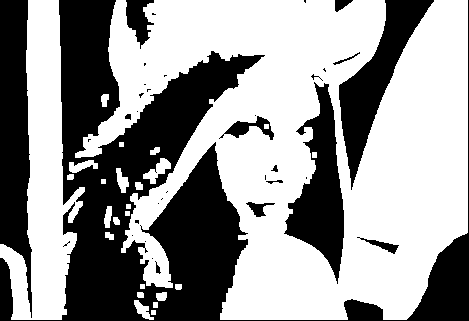

In [127]:
mask2 = [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1], 
        [1, 1, 1, 1, 1], 
        [1, 1, 1, 1, 1]]

mask2 = Mask(mask2)
lenat2 = dilation(mask2, lena)
lenat2 = np.asarray(lenat2, dtype=np.uint8)
cv2_imshow(lenat2)

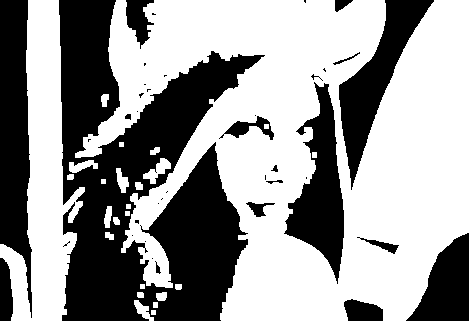

In [121]:
kernel = np.ones((5,5),np.uint8)
img_dilation = cv2.dilate(lena, kernel)
cv2_imshow(img_dilation)

## Abertura

Erosão e depois dilatação

## Fechamento

dilatação e depois erosão